## Bayesian Optimization with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** using Random Forests as surrogate for the hyperparameter response function. We use the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html).


### Procedure

To tune the hyper-parameters of our model we need to:

- define a model
- decide which parameters to optimize
- define the objective function we want to minimize.

### NOTE

Scikit-Optimize will always **minimize** the objective function, so if we want to maximize a function, for example the roc-auc, we need to **negate** the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from skopt import forest_minimize # Bayesian Optimization with RF as surrogate

# for the analysis
from skopt.plots import (
    plot_convergence,
    plot_evaluations,
    plot_objective,
)

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)

In [5]:
# determine the hyperparameter space

param_grid = [
    Integer(10, 120, name="n_estimators"),
    Integer(1, 5, name="max_depth"),
    Real(0.0001, 0.1, prior='log-uniform', name='learning_rate'),
    Real(0.001, 0.999, prior='log-uniform', name="min_samples_split"),
    Categorical(['deviance', 'exponential'], name="loss"),
]

# Scikit-optimize parameter grid is a list
type(param_grid)

list

## Define the model

In [6]:
# set up the gradient boosting classifier

gbm = GradientBoostingClassifier(random_state=0)

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [7]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement for scikit-optimize.

@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-4,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

## Bayesian Optimization with Random Forests (SMAC)

In [8]:
# forest_minimize performs Bayesian Optimization 
# using Random Forests as surrogate

fm_ = forest_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    base_estimator = 'RF', # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
    n_jobs=4,
)

In [9]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % fm_.fun

'Best score=-0.9498'

This procedure didn't find as good hyperparameters as the random search or the search with GPs. The accuracy is lower.

In [10]:
print("""Best parameters:
=========================
- n_estimators = %d
- max-depth = %d
- min_samples_split = %.3f
- learning_rate = %.3f
- loss = %s""" % (fm_.x[0],
                  fm_.x[1],
                  fm_.x[2],
                  fm_.x[3],
                  fm_.x[4],
                  ))

Best parameters:
- n_estimators = 68
- max-depth = 1
- min_samples_split = 0.051
- learning_rate = 0.002
- loss = exponential


## Evaluate convergence of the search

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

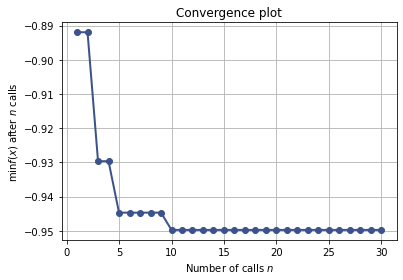

In [11]:
plot_convergence(fm_)

## Partially dependency plots

[plot_objective](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective)

In [12]:
dim_names = ['n_estimators', 'max_depth', 'min_samples_split', 'learning_rate', 'loss']

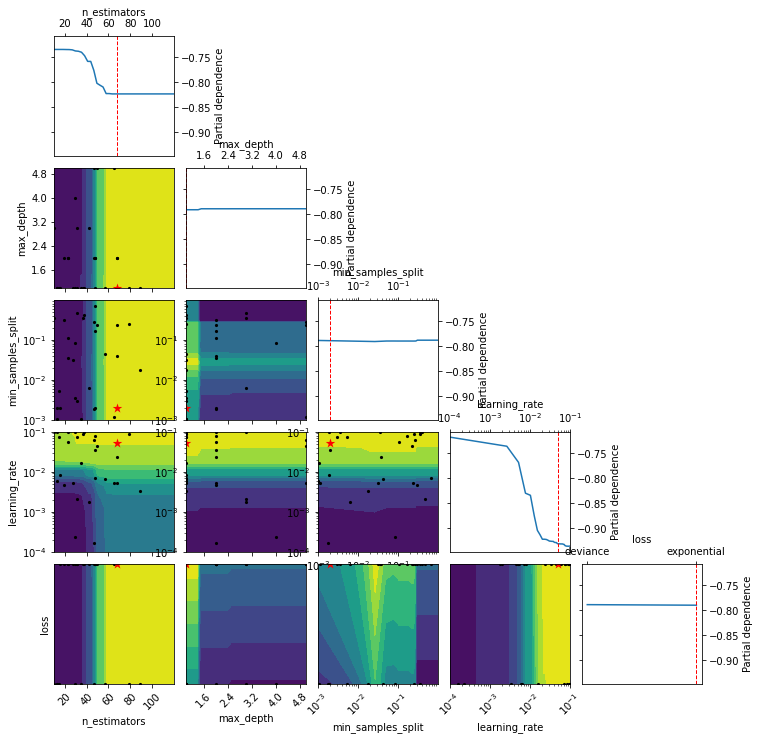

In [13]:
plot_objective(result=fm_, plot_dims=dim_names)
plt.show()

In the diagonal we see the objective function respect to each hyperparameter. Below the diagonal, we see the objective function in colour code, respect to 2 hyperparameters.

## Evaluation order

[plot_evaluations](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html)

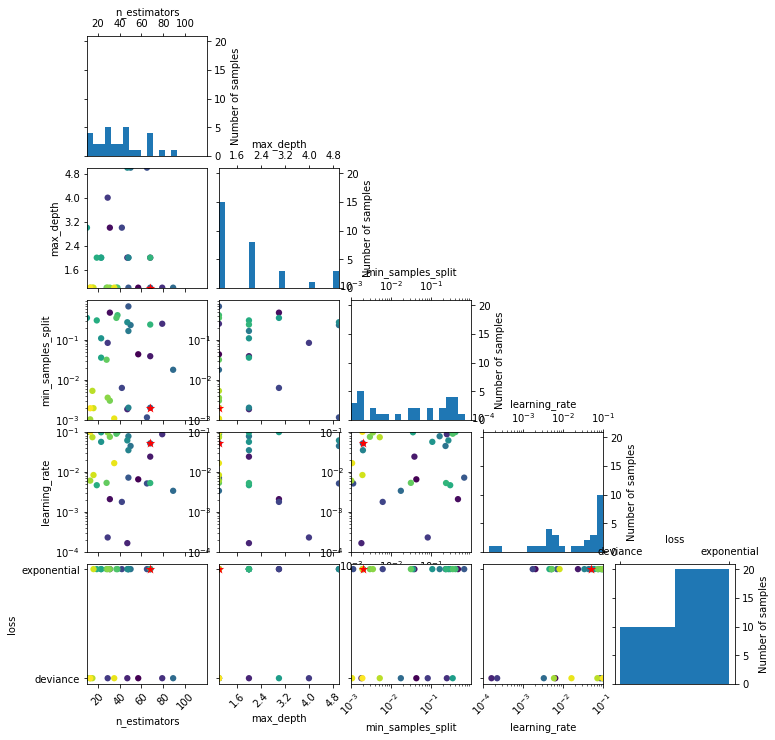

In [14]:
plot_evaluations(result=fm_, plot_dims=dim_names)
plt.show()

We see that for some reason, the search focuses on models with low n_estimators, and probably because of this, it does not manage to find the best hyperparameters, that return a better accuracy.

## The search class

In [16]:
# all together in one dataframe, so we can investigate further

tmp = pd.concat([
    pd.DataFrame(fm_.x_iters),
    pd.Series(fm_.func_vals),
], axis=1)

tmp.columns = dim_names + ['accuracy']
tmp.head()

,n_estimators,max_depth,min_samples_split,learning_rate,loss,accuracy
0,57,1,0.006431,0.043094,deviance,-0.891927
1,31,3,0.002055,0.473077,exponential,-0.625636
2,68,2,0.023723,0.038588,exponential,-0.929654
3,47,2,0.000163,0.001825,deviance,-0.625636
4,79,1,0.086269,0.249533,deviance,-0.944710
